<a href="https://colab.research.google.com/github/ertgrulyksk/Highest-Paid-Athletes-Analysis-with-Python/blob/main/Highest_Paid_Athletes_Analysis_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.style.use("seaborn-pastel")

In [3]:
df = pd.read_excel("Forbes Athlete List 2012-2019.xlsx")
df.head()

,Rank,Name,Pay,Salary/Winnings,Endorsements,Sport,Year
0,#1,Lionel Messi,$127 M,$92 M,$35 M,Soccer,2019
1,#2,Cristiano Ronaldo,$109 M,$65 M,$44 M,Soccer,2019
2,#3,Neymar,$105 M,$75 M,$30 M,Soccer,2019
3,#4,Canelo Alvarez,$94 M,$92 M,$2 M,Boxing,2019
4,#5,Roger Federer,$93.4 M,$7.4 M,$86 M,Tennis,2019


In [4]:
df.Rank = df.Rank.apply(lambda x: int(x.split("#")[1]) if type(x) == np.str else x)
df.Pay = df.Pay.apply(lambda x: float(x.split(" ")[0].split("$")[1]))
df.Endorsements = df.Endorsements.apply(lambda x: float(x.split(" ")[0].split("$")[1]))
df["Salary/Winnings"].replace("-",'$nan M',inplace=True)
df["Salary/Winnings"] = df["Salary/Winnings"].apply(lambda x: float(x.split(" ")[0].split("$")[1]))
df.Sport.replace({"Soccer":"Football",
                  "Football":"American Football",
                 "Mixed Martial Arts":"MMA",
                 "Auto racing":"Racing",
                  "Auto Racing":"Racing",
                  "Basketbal":"Basketball",
                 },inplace=True)

df.columns = ['Rank', 'Name', 'Pay', 'Salary_Winnings', 'Endorsements', 'Sport', 'Year']

<ipython-input-4-514d0d021fcf>:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df.Rank = df.Rank.apply(lambda x: int(x.split("#")[1]) if type(x) == np.str else x)


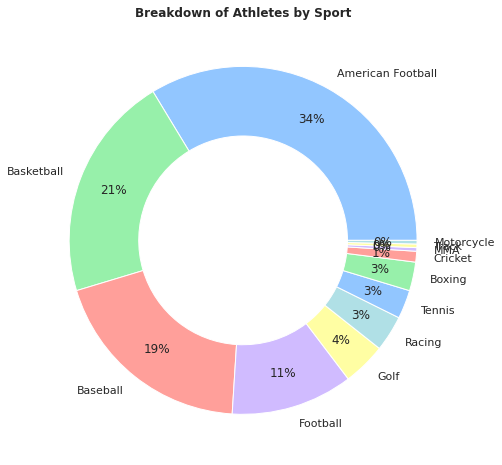

In [5]:
df.groupby("Name").first()["Sport"].value_counts().plot(kind="pie",autopct="%.0f%%",figsize=(8,8),wedgeprops=dict(width=0.4),pctdistance=0.8)
plt.ylabel(None)
plt.title("Breakdown of Athletes by Sport",fontweight="bold")
plt.show()

In [6]:
df.Year = pd.to_datetime(df.Year,format="%Y")

In [7]:
racing_bar_data = df.pivot_table(values="Pay",index="Year",columns="Name")

In [8]:
racing_bar_data.columns[racing_bar_data.isnull().sum() == 0]

Index(['Carmelo Anthony', 'Cristiano Ronaldo', 'Dwight Howard',
       'Justin Verlander', 'LeBron James', 'Lionel Messi', 'Phil Mickelson',
       'Rafael Nadal', 'Roger Federer', 'Tiger Woods'],
      dtype='object', name='Name')

In [9]:
racing_bar_filled = racing_bar_data.interpolate(method="linear").fillna(method="bfill")
racing_bar_filled = racing_bar_filled.cumsum()

In [10]:
racing_bar_filled = racing_bar_filled.resample("1D").interpolate(method="linear")[::7]

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py", line 1769, in _draw_frame
    raise RuntimeError('The animation function must return a '
RuntimeError: The animation function must return a sequence of Artist objects.


TypeError: ignored

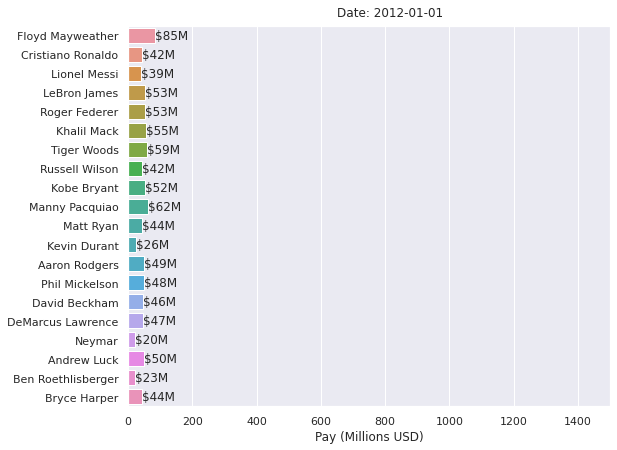

In [43]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

selected  = racing_bar_filled.iloc[-1,:].sort_values(ascending=False)[:20].index
data = racing_bar_filled[selected].round()

fig,ax = plt.subplots(figsize=(9.3,7))
fig.subplots_adjust(left=0.18)
no_of_frames = data.shape[0] #Number of frames

#initiate the barplot with the first rows of the dataframe
bars = sns.barplot(y=data.columns,x=data.iloc[0,:],orient="h",ax=ax)
ax.set_xlim(0,1500)
txts = [ax.text(0,i,0,va="center") for i in range(data.shape[1])]
title_txt = ax.text(650,-1,"Date: ",fontsize=12)
ax.set_xlabel("Pay (Millions USD)")
ax.set_ylabel(None)

def animate(i):
#     print(f"i={i}/{no_of_frames}")
    #get i'th row of data 
    y = data.iloc[i,:]
    
    #update title of the barplot axis
    title_txt.set_text(f"Date: {str(data.index[i].date())}")
    
    #update elements in both plots
    for j, b, in enumerate(bars.patches):
        #update each bar's height
        b.set_width(y[j])
        
        #update text for each bar (optional)
        txts[j].set_text(f"${y[j].astype(int)}M")
        txts[j].set_x(y[j])

anim=FuncAnimation(fig,animate,repeat=False,frames=no_of_frames,interval=1,blit=True)
anim.save('athletes.gif',writer='imagemagick', fps=120)
plt.close(fig)